In [2]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
from scipy.stats import poisson
import pandas as pd

[452 849]
[   0  452  849 1000]
[[0.72781361 0.59772447 0.16196553]]
(1000,)


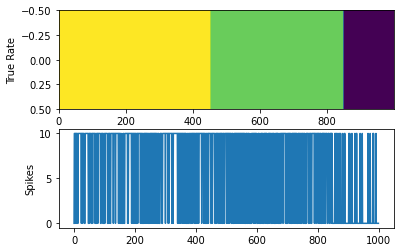

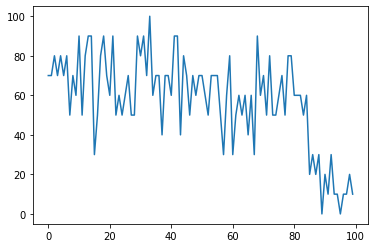

In [65]:
# Some poisson spiking
length = 1000
states = 3
nrns = 1
fit = int(2e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

true_lambda = np.random.random((nrns,states))

print(true_tau)
print(state_inds)
print(true_lambda)

true_r = np.zeros((nrns,length))
for num, val in enumerate(true_lambda.T):
    true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]
  
data_vec = (np.random.random((nrns,length)) < true_r)*10
data_vec = data_vec.flatten()
time = np.arange(len(data_vec))
print(data_vec.shape)
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(2,1)
ax[0].imshow(true_r,aspect='auto')
ax[1].plot(time,data_vec)
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")


bin_width = 10
sharp_data_vec = np.sum(data_vec.reshape((-1,bin_width)),axis=-1)
plt.figure()
plt.plot(sharp_data_vec)

In [507]:
x = np.arange(100)
x_anchors = [ 0.        , 33.5, 66, 99.        ]#[0,33,66,100]
y_anchors = [30.4508939 , 100,  5.54195018, 15.978493  ]#[0.1,0.1,100,50]

In [508]:
def cp_design_mat_np(x, cps):
    return (0.5 * (1.0 + np.sign(np.tile(x[:,None], (1,len(cps))) - cps)))

def return_line_np(x, x_anchors, y_anchors):
    A = cp_design_mat_np(x, x_anchors[:-1])
    B = cp_design_mat_np(x, x_anchors[1:])
    x_diff = np.diff(x_anchors)
    y_diff = np.diff(y_anchors)
    dy_dx = y_diff/x_diff
    state_map = A-B
    dy_dt = state_map.dot(dy_dx)
    y = np.cumsum(dy_dt) + y_anchors[0]
    return y

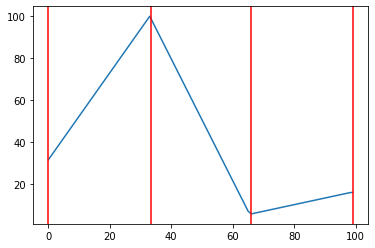

In [509]:
plt.plot(return_line_np(x, x_anchors, y_anchors))
for i in x_anchors:
    plt.axvline(i, color = 'red')

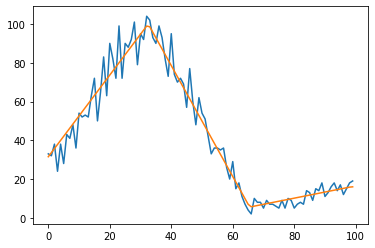

In [492]:
rate = return_line_np(x, x_anchors, y_anchors)
smooth_dat_vec = poisson.rvs(mu = rate)
plt.plot(smooth_dat_vec)
plt.plot(rate)

In [493]:
def cp_design_mat(x, cps):
    return (0.5 * (1.0 + tt.sgn(tt.tile(x[:,None], (1,len(cps.tag.test_value))) - cps)))

def return_line(x, x_anchors, y_anchors):
    A = cp_design_mat(x, x_anchors[:-1])
    B = cp_design_mat(x, x_anchors[1:])
    x_diff = tt.extra_ops.diff(x_anchors)
    y_diff = tt.extra_ops.diff(y_anchors)
    dy_dx = y_diff/x_diff
    state_map = A-B
    dy_dt = state_map.dot(dy_dx)
    y = tt.cumsum(dy_dt) + y_anchors[0]
    return y 

In [545]:
A.tag.test_value

array([[0.5, 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 1. , 0. ],
       [1. , 1. , 0. ],
       [1. , 1. , 0. ],
       [1. , 1. , 0. ],
       [1. , 1. , 0. ],
       [1. , 1. , 0. ],
       [1. , 1. , 0. ],
       [1. , 1. , 0. ],
       [1. , 1. , 0. ],
       [1. , 1. , 0. ],
       [1. , 1. , 0. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. , 1. ],
       [1. , 1. 

In [527]:
# with pm.Model() as cont_model:
    
#     data = pm.Data("data", smooth_dat_vec)
#     # Prior on changepoints
#     a = pm.HalfCauchy('a_tau', 10., shape = states - 1)
#     b = pm.HalfCauchy('b_tau', 10., shape = states - 1)
    
#     even_switches = np.linspace(0,1,states+1)[1:-1]
#     tau_latent_pre = pm.Beta('tau_latent_pre', a, b, 
#                          testval = even_switches,
#                          shape = (states-1))
#     min_anchor = np.array(0).reshape((1))
#     max_anchor = np.array(1).reshape((1))
#     #x_anchors = pm.Deterministic('x_anchors', 
#     #                             tt.concatenate([min_anchor, tau_latent_pre, max_anchor],axis=-1))
#     x_anchors_latent = tt.concatenate([min_anchor, tau_latent_pre, max_anchor],axis=-1)
#     #x_anchors_latent = pm.Deterministic('tau_latent', tt.sort(tau_latent_pre))
#     x_anchors_sorted = tt.sort(x_anchors_latent)
    
#     idx = np.arange(len(smooth_dat_vec))
#     tau = idx.min() + (idx.max() - idx.min()) * x_anchors_sorted
    
#     # y_anchor priors
#     y_anchors = pm.HalfNormal('y_anchors', 30, shape = states+1)

#     lambda_ = pm.Deterministic('lambda_',return_line(x, tau, y_anchors))
#     observation = pm.Poisson("obs", lambda_, observed=data)

In [536]:
with pm.Model() as cont_model:
    
    data = pm.Data("data", smooth_dat_vec)
    
    alpha = pm.HalfNormal('alpha', 3, shape = states)
    delta = pm.Dirichlet('delta', alpha)#[2]*states)
    min_anchor = np.array(0).reshape((1))
    x_anchors = tt.concatenate([min_anchor, tt.cumsum(delta)])
    
    idx = np.arange(len(smooth_dat_vec))
    tau = idx.min() + (idx.max() - idx.min()) * x_anchors
    
    # y_anchor priors
    y_anchors = pm.HalfNormal('y_anchors', 30, shape = states+1)

    lambda_ = pm.Deterministic('lambda_',return_line(x, tau, y_anchors))
    observation = pm.Poisson("obs", lambda_, observed=data)

In [537]:
# this_var = 'lambda_'
# with cont_model:
#     prior_checks = pm.sample_prior_predictive(samples=1000)#, var_names = [this_var])

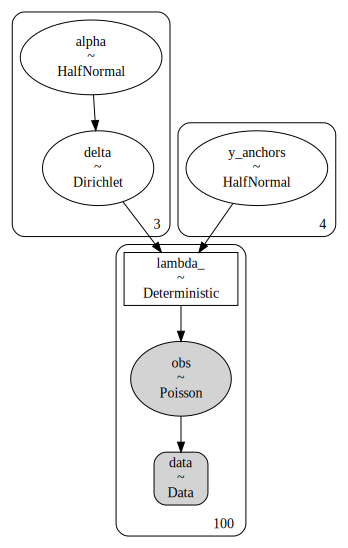

In [538]:
pm.model_to_graphviz(cont_model)

In [539]:
with cont_model:
        trace = pm.sample(step = pm.NUTS(),#target_accept=0.95),
                        tune = 2000, 
                          chains = 8, 
                          cores = 8)

#     approx = pm.fit(n=100000, method=pm.ADVI('full-rank'))
#     trace = approx.sample(draws=20000)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [y_anchors, delta, alpha]


Sampling 8 chains for 2_000 tune and 1_000 draw iterations (16_000 + 8_000 draws total) took 16 seconds.
There were 441 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9070195864893128, but should be close to 0.8. Try to increase the number of tuning steps.
There were 554 divergences after tuning. Increase `target_accept` or reparameterize.
There were 569 divergences after tuning. Increase `target_accept` or reparameterize.
There were 389 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8806300952083741, but should be close to 0.8. Try to increase the number of tuning steps.
There were 733 divergences after tuning. Increase `target_accept` or reparameterize.
There were 726 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6649566809988965, b

In [540]:
# with cont_model:
#     pm.pairplot(trace, var_names = ['delta']);

In [541]:
# with cont_model:
#     pm.traceplot(trace, var_names = ['delta', 'y_anchors']);

In [542]:
with cont_model:
    ppc = pm.sample_posterior_predictive(trace, samples = 100, var_names=["lambda_"])

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


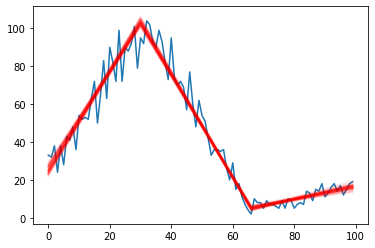

In [543]:
plt.plot(smooth_dat_vec)
plt.plot(ppc['lambda_'].T, color = 'red', alpha = 0.05);

In [270]:
observed_data = {'smooth':smooth_dat_vec, 'sharp':sharp_data_vec}
cont_model_traces = {}
for key, vals in observed_data.items():
    with cont_model:
        # Switch out the observed dataset
        pm.set_data({"data": vals})
        
        approx = pm.fit(n=fit, method=pm.ADVI('full-rank'))
        trace = approx.sample(draws=samples)
        
        #         trace = pm.sample(step = pm.NUTS(),
        #                 tune = 2000, 
        #                   chains = 8, 
        #                   cores = 8)
        
        cont_model_traces[f'{key}_trace'] = trace 
        cont_model_traces[f'{key}_elbo'] = -approx.hist[-1] 

Finished [100%]: Average Loss = 943.61


Finished [100%]: Average Loss = 664.99


In [1177]:
with pm.Model() as sharp_model:
    data = pm.Data("data", smooth_dat_vec)
    #     # Finite, but somewhere on the lower end, Beta prior
    #     a_lambda = 2
    #     b_lambda = 5
    #     lambda_latent = pm.Beta('lambda', 
    #                                     a_lambda, b_lambda, 
    #                                     shape = states,
    #                                        testval = [0.1,0.2,0.3])
    
    lambda_latent = pm.Exponential('lambda', 1/np.mean(data.get_value()), 
                                            shape = states,
                                            testval = [0.1,0.2,0.3])

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((1,len(smooth_dat_vec))),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,len(smooth_dat_vec)))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)
    
    lambda_ = pm.Deterministic('lambda_',
                               pm.math.sum(np.multiply(weight_stack,lambda_latent[:,np.newaxis]),axis=0))
    observation = pm.Poisson("obs", lambda_, observed=data)

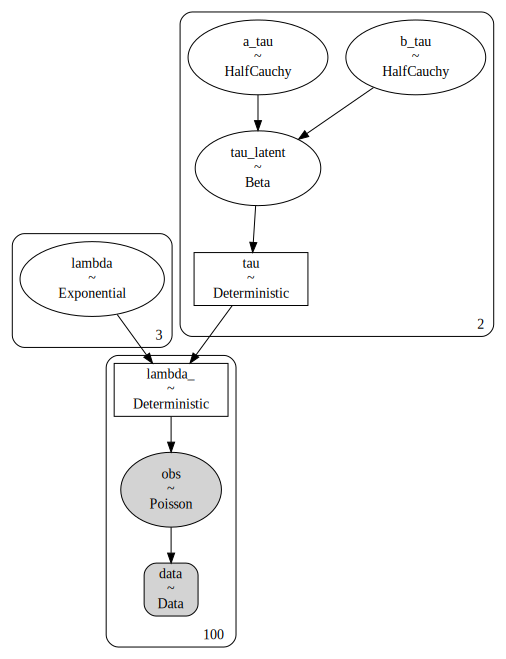

In [1178]:
pm.model_to_graphviz(sharp_model)

In [1179]:
sharp_model_traces = {}
for key, vals in observed_data.items():    
    with sharp_model:
        # Switch out the observed dataset
        pm.set_data({"data": vals})
        
        approx = pm.fit(n=fit, method=pm.ADVI('full-rank'))
        trace = approx.sample(draws=samples)
        
        #         trace = pm.sample(step = pm.NUTS(),
        #                 tune = 2000, 
        #                   chains = 8, 
        #                   cores = 8)
        
        sharp_model_traces[f'{key}_trace'] = trace 
        sharp_model_traces[f'{key}_elbo'] = -approx.hist[-1] 

Finished [100%]: Average Loss = 535.47


Finished [100%]: Average Loss = 627.15


In [1180]:
#cont_model_traces

In [1181]:
#sharp_model_traces

In [1182]:
model_types = ['smooth']*2 + ['sharp']*2
elbo_types = ['smooth_elbo', 'sharp_elbo']
data_types = ['smooth', 'sharp']*2
elbos = [cont_model_traces[x] for x in elbo_types[:2]] + [sharp_model_traces[x] for x in elbo_types[:2]]
out_frame = pd.DataFrame(dict(
                model = model_types,
                data_type = data_types,
                elbo_vals = elbos))

In [1183]:
out_frame.sort_values('data_type')

,model,data_type,elbo_vals
1,smooth,sharp,-688.231840
3,sharp,sharp,-626.241733
0,smooth,smooth,-330.133929
2,sharp,smooth,-533.709176


In [1184]:
# plt.plot(approx.hist)
# plt.figure()
# plt.plot(approx.hist[-5000:])

In [1185]:
# with model:
#     pm.summary(trace)

In [1186]:
# with model:
#     pm.traceplot(trace, var_names = ["init_slope", "init_off", "delta", "tau"])

In [1187]:
# with model:
#     pm.pairplot(trace, var_names = ["init_slope", "init_off", "delta", "tau"])

In [1188]:
trace_types = ['smooth_trace','sharp_trace']
with sharp_model:
    #ppc = pm.sample_posterior_predictive(trace, var_names=["init_slope", "init_off", "tau", "lambda_", "obs"])
    for this_type in trace_types:
        lambda_name = f'{this_type}_lambda'
        this_trace = sharp_model_traces[this_type]
        sharp_model_traces[lambda_name] = pm.sample_posterior_predictive(this_trace, samples = 1000, var_names=["lambda_"])
        
with cont_model:
    #ppc = pm.sample_posterior_predictive(trace, var_names=["init_slope", "init_off", "tau", "lambda_", "obs"])
    for this_type in trace_types:
        lambda_name = f'{this_type}_lambda'
        this_trace = cont_model_traces[this_type]
        cont_model_traces[lambda_name] = pm.sample_posterior_predictive(this_trace, samples = 1000, var_names=["lambda_"])

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [1189]:
# plt.hist(ppc['tau'], bins = 50);

In [1190]:
# plt.plot(np.mean(ppc['obs'],axis=0), alpha = 0.7, linewidth = 5, color = 'k');
# plt.plot(binned_data_vec, alpha = 0.7)

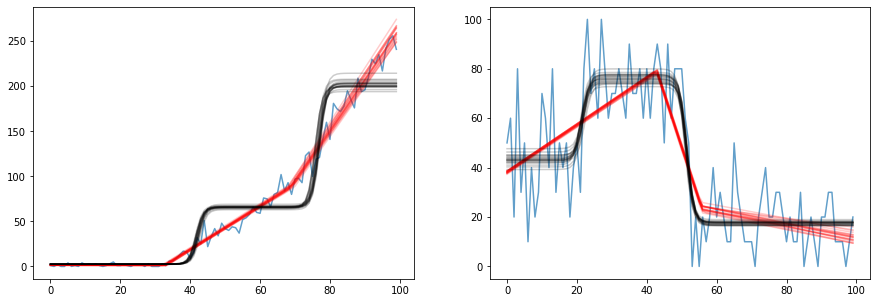

In [1191]:
fig,ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(smooth_dat_vec, alpha = 0.7);
ax[1].plot(sharp_data_vec, alpha = 0.7);


ax[0].plot(cont_model_traces['smooth_trace_lambda']['lambda_'][:20].T, alpha = 0.2, color = 'red');
ax[0].plot(sharp_model_traces['smooth_trace_lambda']['lambda_'][:20].T, alpha = 0.2, color = 'black');

ax[1].plot(cont_model_traces['sharp_trace_lambda']['lambda_'][:20].T, alpha = 0.2, color = 'red');
ax[1].plot(sharp_model_traces['sharp_trace_lambda']['lambda_'][:20].T, alpha = 0.2, color = 'black');
#plt.plot(ppc['lambda_'][::100,:].T, alpha = 0.2, linewidth = 0.5, color = 'k');


In [1192]:
out_frame.pivot(index = 'model', columns = 'data_type', values = 'elbo_vals')[['smooth','sharp']]

data_type,smooth,sharp
model,,
sharp,-533.709176,-626.241733
smooth,-330.133929,-688.231840


In [1169]:
# print(f" Actual slope : {init_slope}, Inferred slope : {np.round(np.median(trace['init_slope']),3)}")
# print(f" Actual offset : {init_offset}, Inferred offset : {np.round(np.median(trace['init_off']),3)}")
# print(f" Actual delta : {act_delta}, Inferred delta : {np.round(np.median(trace['delta'],axis=0),3)}")
# print(f" Actual cps : {(cps/x.max())*len(x)}, Inferred delta : {np.round(np.median(trace['tau'],axis=0),3)}")